In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.utils as vutils
from torch.utils.data import Subset

from WGAN import Critic, Generator

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
batch_size = 64
epochs = 2000
z_dim = 100
c_lr = 5e-5
g_lr = 5e-5
n_critic = 5
clip_threshold = 0.01
data_path = '../data'
image_save_path = './images/wgan'

os.makedirs(image_save_path, exist_ok=True)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

specific_label = 7

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
train_indices = [idx for idx, target in enumerate(trainset.targets) if target is specific_label]
trainset = trainset.data[train_indices]

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
test_indices = [idx for idx, target in enumerate(testset.targets) if target is specific_label]
testset = testset.data[test_indices]

dataset = np.concatenate((trainset, testset), axis=0)
dataset = np.transpose(dataset, (0, 3, 1, 2))
dataset = (dataset - 127.5) / 127.5
dataset = torch.from_numpy(dataset).float()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, drop_last=True)

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


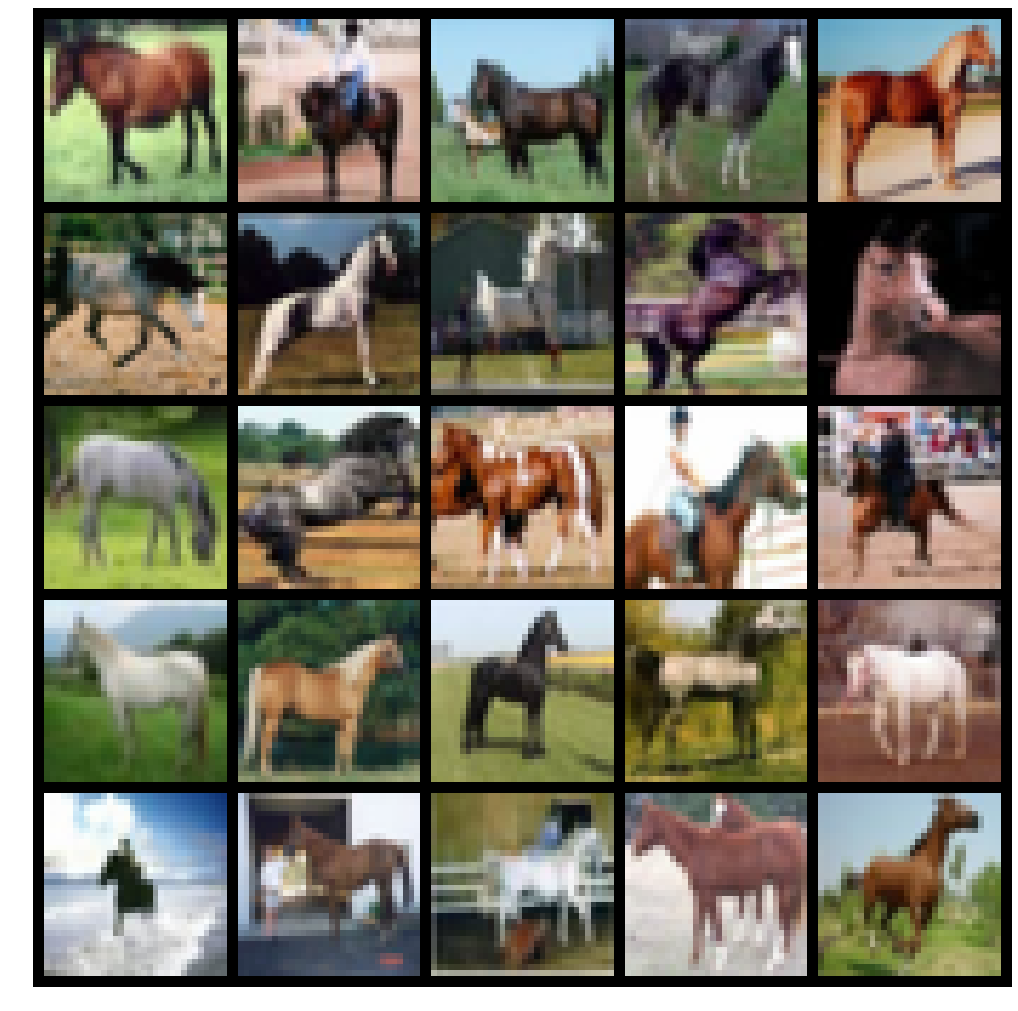

In [5]:
sample_image_batch_size = 25

def imshow(image):
    plt.figure(figsize=(18, 18))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid((image + 1) * 0.5,
                                             nrow=5,
                                             padding=2,
                                             normalize=True), (1, 2, 0)))
    plt.savefig(os.path.join(image_save_path, 'sample_images.png'))
    
images = next(iter(dataloader))
imshow(images[:sample_image_batch_size])

In [6]:
generator = Generator(z_dim).to(device)
critic = Critic().to(device)
generator.train()
critic.train()

Critic(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=1, bias=True)
)

In [7]:
print(generator)

Generator(
  (linear): Linear(in_features=100, out_features=2048, bias=True)
  (batch_norm): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (layers): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Upsample(scale_factor=2.0, mode=nearest)
    (9): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momen

In [8]:
print(critic)

Critic(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=1, bias=True)
)


In [9]:
real_label = 1.
fake_label = -1.

d_optimizer = optim.RMSprop(params=critic.parameters(), lr=c_lr)
g_optimizer = optim.RMSprop(params=generator.parameters(), lr=g_lr)
# d_optimizer = optim.Adam(params=critic.parameters(), lr=c_lr, betas=[0.5, 0.999])
# g_optimizer = optim.Adam(params=generator.parameters(), lr=g_lr, betas=[0.5, 0.999])

In [10]:
g_losses = []
d_losses = []
d_losses_real = []
d_losses_fake = []

one = torch.FloatTensor([1]).to(device)
mone = one * -1

for epoch in range(epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_d_loss_real = 0.0
    epoch_d_loss_fake = 0.0
    for i, inputs in enumerate(dataloader):
        critic.zero_grad()
        
        # 진짜 데이터로 학습
        inputs = inputs.to(device)
        
        output = critic(inputs)
        d_loss_real = -output.mean().view(-1)
        
        # 가짜 데이터로 학습
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = generator(noise)
        output = critic(fake)
        d_loss_fake = output.mean().view(-1)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        epoch_d_loss += d_loss
        epoch_d_loss_real += d_loss_real
        epoch_d_loss_fake += d_loss_fake
        
        # 1-Lipshitz continuous function
        for p in critic.parameters():
            p.data.clamp_(-clip_threshold, clip_threshold)
            
        if (i + 1) % n_critic == 0:                    
            for p in critic.parameters():
                p.requires_grad = False
            
            # Generator
            generator.zero_grad()
            noise = torch.randn(batch_size, z_dim, device=device)
            g_output = generator(noise)
            output = critic(g_output)
            g_loss = -output.mean().view(-1)
            g_loss.backward()
            g_optimizer.step()
            
            epoch_g_loss += g_loss
            
            for p in critic.parameters():
                p.requires_grad = True
        
    epoch_d_loss /= len(dataloader)
    epoch_d_loss_real /= len(dataloader)
    epoch_d_loss_fake /= len(dataloader)
    epoch_g_loss /= len(dataloader) / n_critic            
    
    d_losses.append(epoch_d_loss.item())
    d_losses_real.append(epoch_d_loss_real.item())
    d_losses_fake.append(epoch_d_loss_fake.item())
    g_losses.append(epoch_g_loss.item())
    
    print('%d [D loss: (%.3f)(R %.3f, F %.3f)] [G loss: %.3f]' %
          (epoch, epoch_d_loss, epoch_d_loss_real, epoch_d_loss_fake, epoch_g_loss))
    
    if epoch + 1 in [50, 100, 200, 500, 1000, 2000]:
        plt.figure(figsize=(20, 20))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid((fake[:25] + 1) * 0.5,
                                                 nrow=5,
                                                 padding=2,
                                                 normalize=False).detach().cpu(), (1, 2, 0)))
        plt.savefig(os.path.join(image_save_path, f'epoch_{epoch + 1}.png'))


0 [D loss: (-6.024)(R 9.950, F -15.974)] [G loss: 18.049]
1 [D loss: (-17.695)(R 47.253, F -64.947)] [G loss: 66.792]
2 [D loss: (-5.974)(R 34.021, F -39.995)] [G loss: 39.346]
3 [D loss: (-8.622)(R 16.665, F -25.287)] [G loss: 25.238]
4 [D loss: (-4.296)(R 10.687, F -14.983)] [G loss: 15.262]
5 [D loss: (-0.713)(R 5.911, F -6.624)] [G loss: 8.093]
6 [D loss: (-1.548)(R 6.851, F -8.399)] [G loss: 8.705]
7 [D loss: (-5.162)(R 6.358, F -11.520)] [G loss: 11.985]
8 [D loss: (-6.622)(R 4.788, F -11.410)] [G loss: 11.490]
9 [D loss: (-6.212)(R 2.948, F -9.160)] [G loss: 9.195]
10 [D loss: (-6.040)(R 1.914, F -7.954)] [G loss: 7.719]
11 [D loss: (-5.916)(R 1.359, F -7.274)] [G loss: 7.034]
12 [D loss: (-5.043)(R 1.471, F -6.514)] [G loss: 6.239]
13 [D loss: (-4.575)(R 1.406, F -5.982)] [G loss: 6.010]
14 [D loss: (-4.611)(R 0.897, F -5.508)] [G loss: 5.683]
15 [D loss: (-4.158)(R 0.039, F -4.197)] [G loss: 4.318]
16 [D loss: (-4.123)(R -0.727, F -3.396)] [G loss: 4.103]
17 [D loss: (-4.440)(

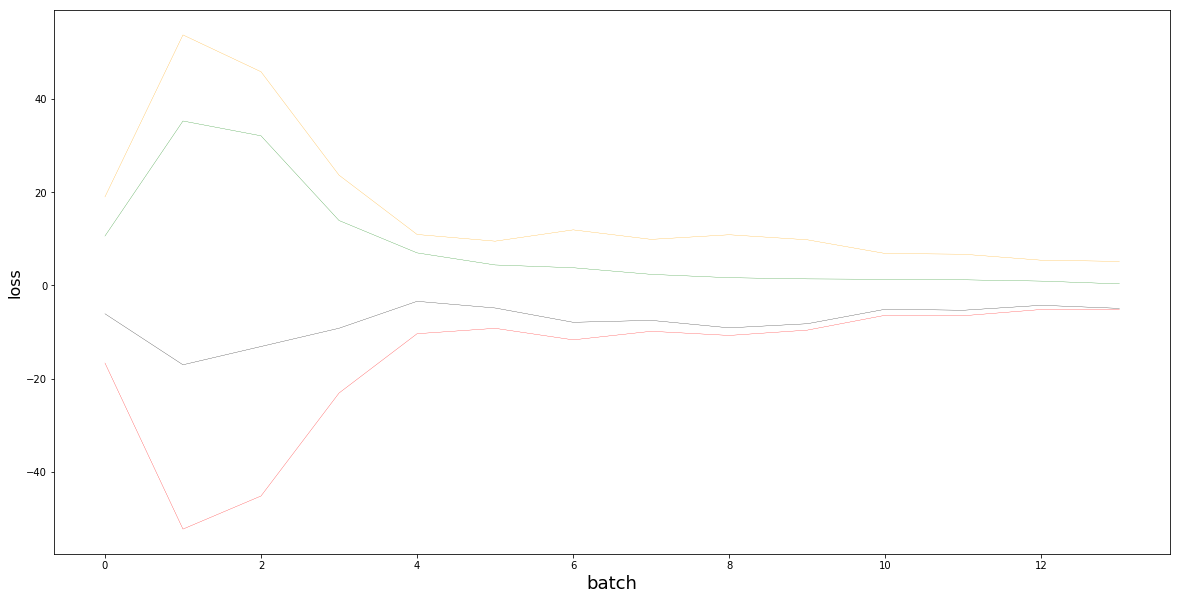

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in d_losses], color='black', linewidth=0.25)
plt.plot([x for x in d_losses_real], color='green', linewidth=0.25)
plt.plot([x for x in d_losses_fake], color='red', linewidth=0.25)
plt.plot([x for x in g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.savefig(os.path.join(image_save_path, f'loss_graph.png'))

In [ ]:
def compare_images(img1, img2):
    return torch.mean(torch.abs(img1 - img2))

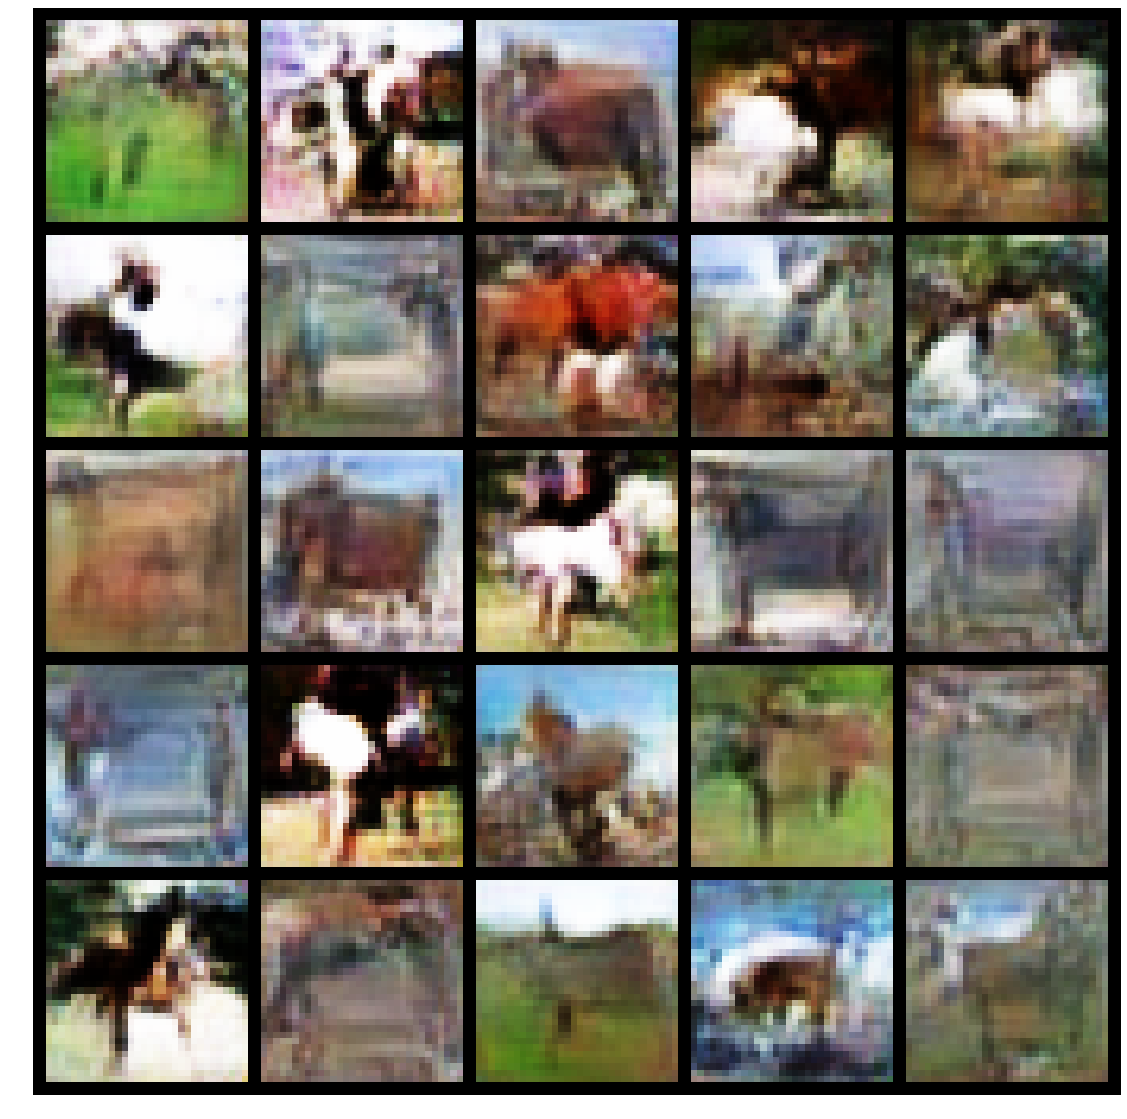

In [ ]:
noise = torch.randn(25, z_dim, device=device)

gen_imgs = generator(noise).detach().cpu()

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_imgs / 2 + 0.5,
                                         nrow=5,
                                         padding=2,
                                         normalize=False), (1, 2, 0)))
plt.savefig(os.path.join(image_save_path, f'gen_imgs.png'))

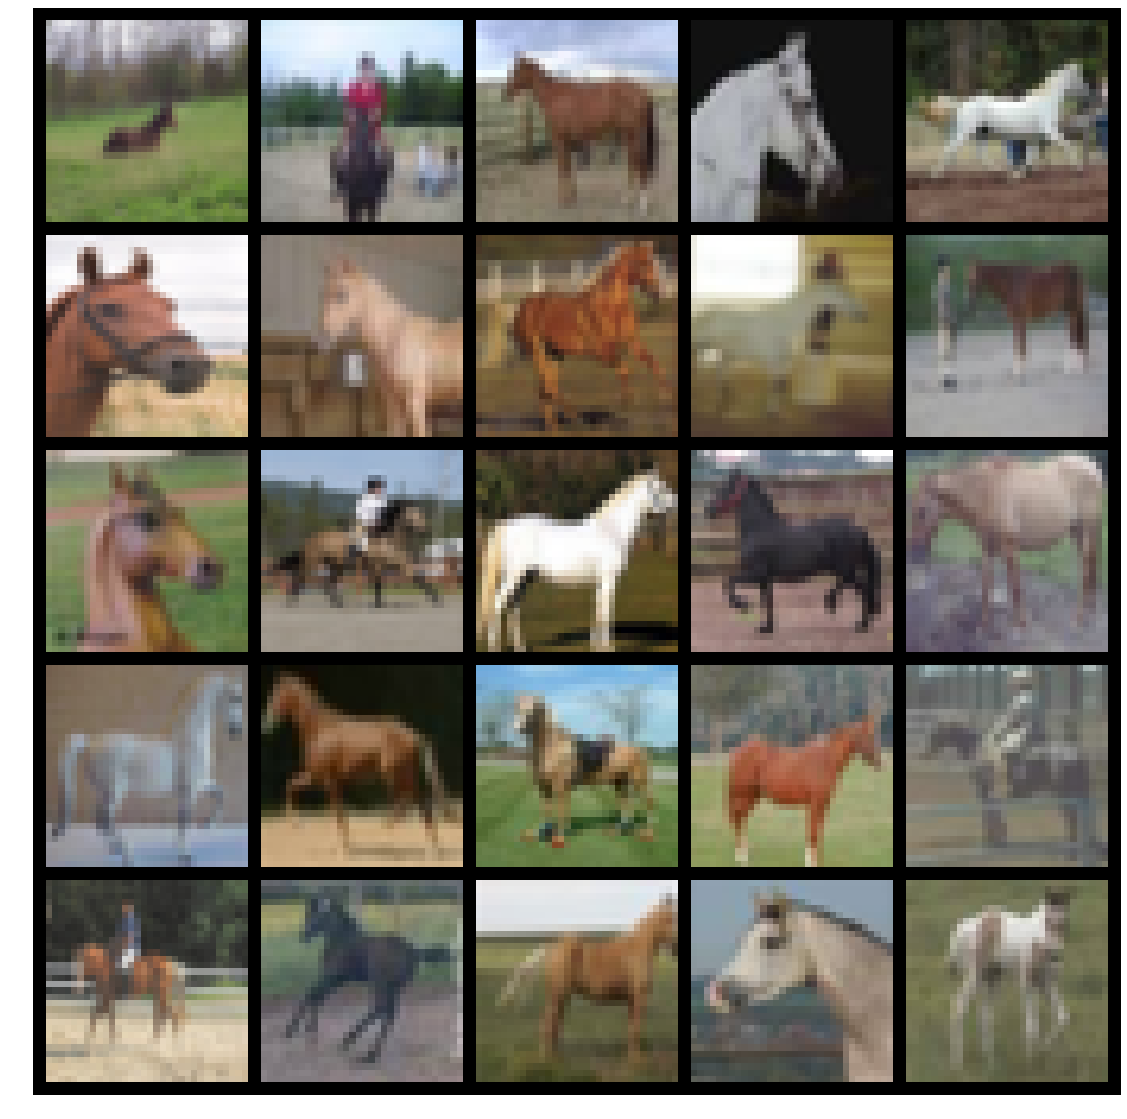

In [ ]:
closest_imgs = []

for gen_img in gen_imgs:
    min_val = 9999
    min_img = dataset[0]
    for real_imgs in dataloader:
        for real_img in real_imgs:
            real_img = real_img.numpy()
            diff = compare_images(gen_img, real_img)
            if min_val > diff:
                min_val = diff
                min_img = np.copy(real_img)
        
    closest_imgs.append(min_img)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid((torch.FloatTensor(closest_imgs) + 1) * 0.5,
                                         nrow=5,
                                         padding=2,
                                         normalize=False), (1, 2, 0)))
plt.savefig(os.path.join(image_save_path, f'closest_real_imgs.png'))

